
# **<center><span style="color:#00BFC4;"> Imports  </span></center>**

Upload the raw dataset and/or any intermediate artifacts.

In [ ]:
import google.colab
## basic imports
import os
import ast
import pandas as pd
import numpy as np 
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
from tqdm.notebook import trange

## metrics imports 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


## torch library imports 
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

## Hyperparameters 
RANDOM_STATE = 12
TEST_SIZE = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 1
EPOCHS = 1
HIDDEN_SIZE = 200
EMBEDDING_DIM = 100
DEVICE = "cuda"


UPLOAD_ROOT = '/content'
DATA_FILE = 'S1_File.txt'

if not os.path.isfile(os.path.join(UPLOAD_ROOT, DATA_FILE)):
  google.colab.files.upload()

assert os.path.isfile(os.path.join(UPLOAD_ROOT, DATA_FILE))

Saving S1_File.txt to S1_File.txt


# **<center><span style="color:#00BFC4;">Data Loading and Overview </span></center>**

Parse the raw dataset.

In [ ]:

COLUMN_PATIENT = 'PID'
COLUMN_DATE = 'DAY_ID'
COLUMN_DIAGNOSIS = 'DX_GROUP_DESCRIPTION'
COLUMN_SERVICE = 'SERVICE_LOCATION'

RawData = pd.read_csv(os.path.join(UPLOAD_ROOT, DATA_FILE), sep='\t')
assert COLUMN_PATIENT in RawData.columns
assert COLUMN_DATE in RawData.columns
assert COLUMN_DIAGNOSIS in RawData.columns
assert COLUMN_SERVICE in RawData.columns
RawData.head()

,PID,DAY_ID,DX_GROUP_DESCRIPTION,SERVICE_LOCATION,OP_DATE
0,1,73888,ANGINA PECTORIS,DOCTORS OFFICE,74084
1,1,73888,MONONEURITIS OF UPPER LIMB AND MONONEURITIS MU...,DOCTORS OFFICE,74084
2,1,73888,SYMPTOMS INVOLVING RESPIRATORY SYSTEM AND OTHE...,DOCTORS OFFICE,74084
3,1,73880,ACUTE APPENDICITIS,INPATIENT HOSPITAL,74084
4,1,73880,DIABETES MELLITUS,INPATIENT HOSPITAL,74084


# **<center><span style="color:#00BFC4;">Data Exploration & Processing </span></center>**

Tally the occurrence of different diagnosis in the raw dataset.

In [ ]:
DiagnosisTally = RawData.groupby("DX_GROUP_DESCRIPTION").size().to_frame('COUNT').sort_values(by='COUNT', ascending=False).reset_index()
DiagnosisTally.head()

,DX_GROUP_DESCRIPTION,COUNT
0,CARDIAC DYSRHYTHMIAS,35522
1,ESSENTIAL HYPERTENSION,32998
2,HEART FAILURE,32117
3,DIABETES MELLITUS,30376
4,DISORDERS OF LIPOID METABOLISM,20157


In [ ]:
fig = px.bar(DiagnosisTally["COUNT"], color_continuous_scale="Emrld")
fig.update_xaxes(title = "Different Diagnosis")
fig.update_yaxes(title = "Diagnosis Count")

Diagnosis description will be used as vocab list. The number of distinct diagnosis is huge.

In [ ]:
DiagnosisTally.shape[0]

1412

**Remove diagnosis words with rare occurrence ** to optimize training and reduce noise. The vocab list is now much smaller.

In [ ]:
RARE_OCCURRENCE = 100
print("Length of Vocab List before removal  = ", DiagnosisTally.shape[0])

DiagnosisTally = DiagnosisTally[DiagnosisTally['COUNT'] > RARE_OCCURRENCE]
DiagnosisTally = DiagnosisTally.sort_values(by='COUNT', ascending=False)
print("Length of Vocab List after removal  = ", DiagnosisTally.shape[0])

Length of Vocab List before removal  =  1412
Length of Vocab List after removal  =  490


### <span style="color:#e76f51;"> Vocab Dictionary  Construction :  </span>

Constructing a word to index dictionary `Vocab`.

In [ ]:
# ## Defining Vocab
# vocab = DiagnosisTally.drop(columns=['COUNT'])
# vocab = vocab.reset_index()

# ## Saving Vocab ot csv file
# vocab.to_csv("vocab.csv", index=False)

ARTIFACT_VOCAB = 'Artifact_Vocab.csv'

if not os.path.isfile(os.path.join(UPLOAD_ROOT, ARTIFACT_VOCAB)):
  Vocab = DiagnosisTally.drop(columns=['COUNT'])
  Vocab = Vocab.reset_index()
  Vocab['index'] = Vocab['index']
  Vocab.to_csv(ARTIFACT_VOCAB, index=False)

Vocab = pd.read_csv(os.path.join(UPLOAD_ROOT, ARTIFACT_VOCAB))
assert 'index' in Vocab
assert COLUMN_DIAGNOSIS in Vocab
Vocab.head()

,index,DX_GROUP_DESCRIPTION
0,0,CARDIAC DYSRHYTHMIAS
1,1,ESSENTIAL HYPERTENSION
2,2,HEART FAILURE
3,3,DIABETES MELLITUS
4,4,DISORDERS OF LIPOID METABOLISM


Encode diagnosis data using `Vocab`.

In [ ]:
# encoded_data = data.join(other=vocab.set_index('DX_GROUP_DESCRIPTION'), on='DX_GROUP_DESCRIPTION', how='inner')
# encoded_data = encoded_data.groupby(['PID', 'DAY_ID'])['index'].apply(lambda x: list(set(list(x)))).reset_index()
# encoded_data = encoded_data.rename(columns={'index': 'DX_GROUP_DESCRIPTION'})
# encoded_data.to_csv("encoded_data.csv")

import ast

ARTIFACT_ENCODED_RAW_DATA = 'Artifact_EncodedRawData.csv'

if not os.path.isfile(os.path.join(UPLOAD_ROOT, ARTIFACT_ENCODED_RAW_DATA)):
  EncodedRawData = RawData.join(other=Vocab.set_index(COLUMN_DIAGNOSIS), on=COLUMN_DIAGNOSIS, how='inner')
  EncodedRawData = EncodedRawData.groupby([COLUMN_PATIENT, COLUMN_DATE])['index'].apply(lambda x: list(set(list(x)))).reset_index()
  EncodedRawData = EncodedRawData.rename(columns={'index': COLUMN_DIAGNOSIS})
  EncodedRawData.to_csv(ARTIFACT_ENCODED_RAW_DATA, index=False)

EncodedRawData = pd.read_csv(os.path.join(UPLOAD_ROOT, ARTIFACT_ENCODED_RAW_DATA), converters={COLUMN_DIAGNOSIS: ast.literal_eval})
assert COLUMN_PATIENT in EncodedRawData
assert COLUMN_DATE in EncodedRawData
assert COLUMN_DIAGNOSIS in EncodedRawData
EncodedRawData.head()

,PID,DAY_ID,DX_GROUP_DESCRIPTION
0,1,73546,[26]
1,1,73564,"[12, 5]"
2,1,73571,"[16, 51, 12, 85]"
3,1,73586,"[3, 4, 7, 18, 479]"
4,1,73617,[18]


Extract hospitalization events from raw data.

In [ ]:
# hos_events = data[data['SERVICE_LOCATION'] == 'INPATIENT HOSPITAL']
# hos_events = hos_events.drop(columns=['SERVICE_LOCATION'])
# hos_events = hos_events.groupby(['PID', 'DAY_ID']).size().to_frame('DIAGNOSIS_COUNT').reset_index()
# hos_events = hos_events.drop(columns='DIAGNOSIS_COUNT')
# hos_events.head()

SERVICE_HOSPITALIZATION = 'INPATIENT HOSPITAL'

HospitalizationEvents = RawData[RawData[COLUMN_SERVICE] == SERVICE_HOSPITALIZATION]
HospitalizationEvents = HospitalizationEvents.drop(columns=[COLUMN_SERVICE])
HospitalizationEvents = HospitalizationEvents.groupby([COLUMN_PATIENT, COLUMN_DATE]).size().to_frame('DIAGNOSIS_COUNT').reset_index()
HospitalizationEvents = HospitalizationEvents.drop(columns='DIAGNOSIS_COUNT')
HospitalizationEvents.head()

,PID,DAY_ID
0,1,73874
1,1,73879
2,1,73880
3,1,74043
4,2,74195


# **<center><span style="color:#00BFC4;">Dataset Creation </span></center>**

For every patients' event, identify if there exists a readmission within 30 days. Build a readmission ground truth dataset.

In [ ]:
# READMISSION_DAYS = 30

# if not os.path.isfile("/content/Dataset.csv"):
#     def hasReadmission(hos_events, patient, date):
#         patientEvents = hos_events[hos_events['PID'] == patient]
#         return patientEvents[(date < patientEvents['DAY_ID']) & (patientEvents['DAY_ID'] < (date + READMISSION_DAYS))].shape[0] > 0
#     Dataset = data
#     Dataset['READMISSION'] = Dataset.apply(lambda x: int(hasReadmission(hos_events, x['PID'], x['DAY_ID'])), axis=1)
#     Dataset.to_csv("/content/Dataset.csv", index=False)

# Dataset = pd.read_csv("/content/Dataset.csv", converters={'DX_GROUP_DESCRIPTION': ast.literal_eval})

SyntaxError: ignored

In [ ]:

# ARTIFACT_DATASET = 'Artifact_Dataset.csv'
# READMISSION_DAYS = 30
ARTIFACT_DATASET = 'Dataset.csv'
READMISSION_DAYS = 30
if not os.path.isfile(os.path.join(UPLOAD_ROOT, ARTIFACT_DATASET)):
  def hasReadmission(hospitalizationEvents, patient, date):
    patientEvents = hospitalizationEvents[hospitalizationEvents[COLUMN_PATIENT] == patient]
    return patientEvents[(date < patientEvents[COLUMN_DATE]) & (patientEvents[COLUMN_DATE] < (date + READMISSION_DAYS))].shape[0] > 0
  Dataset = EncodedRawData
  Dataset['READMISSION'] = Dataset.apply(lambda x: int(hasReadmission(HospitalizationEvents, x[COLUMN_PATIENT], x[COLUMN_DATE])), axis=1)
  Dataset.to_csv(ARTIFACT_DATASET, index=False)

Dataset = pd.read_csv(os.path.join(UPLOAD_ROOT, ARTIFACT_DATASET), converters={COLUMN_DIAGNOSIS: ast.literal_eval})
assert COLUMN_PATIENT in Dataset
assert COLUMN_DATE in Dataset
assert COLUMN_DIAGNOSIS in Dataset
assert 'READMISSION' in Dataset


In [ ]:
print(f'\033[94mNumber of rows in train data: {Dataset.shape[0]}')
print(f'\033[94mNumber of columns in train data: {Dataset.shape[1]}')
print(f'\033[94mNumber of values in train data: {Dataset.count().sum()}')

Number of rows in train data: 230685
Number of columns in train data: 4
Number of values in train data: 922740


#### <span style="color:#e76f51;"> Stats of created dataset </span>

In [ ]:
Dataset.describe()

,PID,DAY_ID,READMISSION
count,230685.000000,230685.000000,230685.000000
mean,1508.594620,74574.289858,0.192834
std,864.209802,432.130542,0.394525
min,1.000000,72954.000000,0.000000
25%,750.000000,74257.000000,0.000000
50%,1515.000000,74561.000000,0.000000
75%,2255.000000,74879.000000,0.000000
max,3000.000000,76163.000000,1.000000


**Day IDs Distribution**

In [ ]:
import plotly.express as px 

fig = px.histogram(data_frame=  Dataset, x  = "DAY_ID",color = "READMISSION", marginal="box",color_discrete_sequence=['#58D68D','#DE3163'])
fig.update_xaxes(title = "Day IDs")
fig.update_yaxes(title = "Count")

# **<center><span style="color:#00BFC4;">Data Loaders for Training  </span></center>**

Build the dataset `Documents` and the ground truth `Labels`.

`Documents` is a list, each entry is the information of 1 single `Patient`.

```
Documents = [Patient_1, Patient_2]
```

Each `Patient_i` is a list, each entry is the information of 1 single `Visit`.

```
Patient_i = [Visit_1, Visit_2]
```

Each `Visit_i` is a list of encoded diagnosis.

```
Visit_i = [Diag_1, Diag_2]
```

In [ ]:
Documents = Dataset.groupby([COLUMN_PATIENT])[COLUMN_DIAGNOSIS].apply(list).reset_index()[COLUMN_DIAGNOSIS].tolist()
Labels = Dataset.groupby([COLUMN_PATIENT])['READMISSION'].max().reset_index()['READMISSION'].tolist()
len(Documents)

3000

**Target Labels Distribution**

In [ ]:
TARGET = "Label"
target_df = pd.DataFrame(pd.DataFrame(Labels).value_counts(), columns = ["count"], )
target_df["Label"] = [1,0]
target_df
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / len(Labels)))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 /  len(Labels)))
fig.show()

Percentage of Transported = 0: 9.97 %
Percentage of Transported = 1: 90.03 %


Split training and testing sets.

In [ ]:
## Custom Dataset Loader Class
class PatientDataset(torch.utils.data.Dataset):
    def __init__(self, documents, labels):
        self.x = documents
        self.y = labels
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        


## spliting train and test dataset
X_train, X_test, y_train, y_test = train_test_split(Documents, Labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Loading datasets form train and test splits
TrainingDataset = PatientDataset(X_train, y_train)
TestingDataset = PatientDataset(X_test, y_test)

In [ ]:
# import sklearn.model_selection
# import torch.utils.data

# RANDOM_STATE = 42
# TEST_SIZE = 0.2

# class PatientDataset(torch.utils.data.Dataset):
#   def __init__(self, documents, labels):
#     self.x = documents
#     self.y = labels
#   def __len__(self):
#     return len(self.x)
#   def __getitem__(self, index):
#     return self.x[index], self.y[index]

# ## spliting train and test dataset
# x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(Documents, Labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)


# ## Loading datasets form train and test splits
# TrainingDataset = PatientDataset(x_train, y_train)
# TestingDataset = PatientDataset(x_test, y_test)
# len(TrainingDataset)

2400

Define the dataset loader.

In [ ]:
## defining collate function 
def collateFunc(data):
    sequences, labels = zip(*data)
    numPatients = len(sequences)
    numVisits = [len(patient) for patient in sequences]
    maxNumVisits = max(numVisits)
    x = torch.zeros((numPatients, maxNumVisits, DiagnosisTally.shape[0]), dtype=torch.float)
    for patientIndex, patient in enumerate(sequences):
        for visitIndex, visit in enumerate(patient):
            for diagnosis in visit:
                x[patientIndex][visitIndex][diagnosis] = 1
    x_masks = torch.sum(x, dim=-1) > 0
    y = torch.tensor(labels, dtype=torch.float)
    return x, x_masks, y

## Constructing dataloader 
TrainingLoader = torch.utils.data.DataLoader(TrainingDataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collateFunc)
TestingLoader = torch.utils.data.DataLoader(TestingDataset, batch_size=BATCH_SIZE, collate_fn=collateFunc)

In [ ]:
# ## defining collate function 
# BATCH_SIZE = 1
# MAX_NUM_VISITS = max(len(patient) for patient in Documents)
# MAX_NUM_DIAGNOSIS = DiagnosisTally.shape[0]

# def collateFunc(data):
#   sequences, labels = zip(*data)
#   numPatients = len(sequences)
#   x = torch.zeros((numPatients, MAX_NUM_VISITS, MAX_NUM_DIAGNOSIS), dtype=torch.float)
#   for patientIndex, patient in enumerate(sequences):
#     for visitIndex, visit in enumerate(patient):
#       for diagnosis in visit:
#         x[patientIndex][visitIndex][diagnosis] = 1
#   x_masks = torch.sum(x, dim=-1) > 0
#   y = torch.tensor(labels, dtype=torch.float)
#   return x, x_masks, y

# ## Constructing dataloader 
# TrainingLoader = torch.utils.data.DataLoader(TrainingDataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collateFunc)
# TestingLoader = torch.utils.data.DataLoader(TestingDataset, batch_size=BATCH_SIZE, collate_fn=collateFunc)
# len(TrainingLoader)

2400

# **<center><span style="color:#00BFC4;">CONTENT Model  </span></center>**

In [ ]:
class GruNet(nn.Module):
    def __init__(self, inputSize):
        super().__init__()
        self.gru = nn.GRU(input_size=inputSize, hidden_size=HIDDEN_SIZE, batch_first=True)
        self.fc = nn.Linear(in_features=HIDDEN_SIZE, out_features=1)
    def forward(self, x):
        _, h = self.gru(x)
        out = self.fc(h)
        return out

class RecogNet(nn.Module):
    def __init__(self, inputSize):
        super().__init__()
        self.fc1 = nn.Linear(in_features=inputSize, out_features=HIDDEN_SIZE)
        self.fc2 = nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE)
        self.fc3 = nn.Linear(in_features=HIDDEN_SIZE, out_features=1)
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out

class ContentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = GruNet(Vocab.shape[0])
        self.recog = RecogNet(Vocab.shape[0])
        self.fc = nn.Linear(in_features=2, out_features=1)
    def forward(self, x, masks):
        batch_size = x.shape[0]
        rnnOut = self.rnn(x)
        recogOut = self.rnn(x)
        logits = self.fc(torch.cat((rnnOut, recogOut), dim=-1))
        probs = torch.sigmoid(logits)
        return probs.view(batch_size)

model = ContentNet()
model = model.to(DEVICE)
print(model)

ContentNet(
  (rnn): GruNet(
    (gru): GRU(490, 200, batch_first=True)
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (recog): RecogNet(
    (fc1): Linear(in_features=490, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (fc3): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


Model training.

In [ ]:
def eval(model, dataLoader):
    model.to(DEVICE)
    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    for x, masks, y in dataLoader:
        x = x.to(DEVICE)
        masks = masks.to(DEVICE)
        y = y.to(DEVICE)
        y_hat = model(x, masks)
        y_score = torch.cat((y_score, y_hat.detach().to('cpu')), dim=0)
        y_hat = (y_hat > 0.5).int()
        y_pred = torch.cat((y_pred, y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)
    p, r, f, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='binary')
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_score)
    fpr, tpr,_  = roc_curve(y_true=y_true, y_score=y_score)
    return p, r, f, roc_auc, (fpr,tpr)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),LEARNING_RATE )
training_losses = []

for epoch in trange(EPOCHS):
    model.train()
    train_loss = 0
    for x, x_masks, y in TrainingLoader:
        loss = None
        optimizer.zero_grad()
        x = x.to(DEVICE)
        x_masks = x_masks.to(DEVICE)
        y = y.to(DEVICE)
        outputs = model(x, x_masks)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(TrainingLoader)
    p, r, f, roc_auc, curve = eval(model, TrainingLoader)
    print('Epoch: {} \t Training   p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'.format(epoch+1, p, r, f, roc_auc))
    test_p, test_r, test_f, test_roc_auc, test_curve = eval(model, TestingLoader)
    print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'.format(epoch+1, test_p, test_r, test_f, test_roc_auc))
    training_losses.append(train_loss)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 	 Training   p: 0.90, r:1.00, f: 0.95, roc_auc: 0.92
Epoch: 1 	 Validation p: 0.90, r:1.00, f: 0.95, roc_auc: 0.87


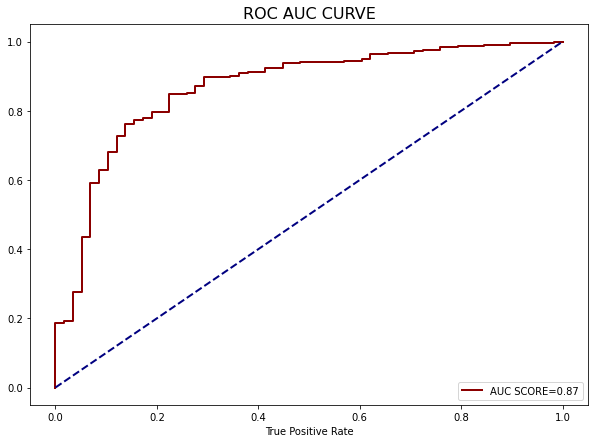

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(test_curve[0],test_curve[1],color='darkred', lw=2, label="AUC SCORE="+str(round(test_roc_auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE', fontsize = 16)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

# **<center><span style="color:#00BFC4;">PROPOSED Model</span></center>**

In [ ]:
EMBEDDING_DIM = 200
HIDDEN_SIZE = 200
DENSE_INPUT_DIM = 128
class GruNet(nn.Module):
    def __init__(self, inputSize):
        super().__init__()
        self.gru = nn.GRU(input_size=inputSize, hidden_size=HIDDEN_SIZE, batch_first=True)
        self.fc = nn.Linear(in_features=HIDDEN_SIZE, out_features=1)
    def forward(self, x):
        _, h = self.gru(x)
        out = self.fc(h)
        return out

class RecogNet(nn.Module):
    def __init__(self, inputSize):
        super().__init__()
        self.fc1 = nn.Linear(in_features=inputSize, out_features=DENSE_INPUT_DIM)
        self.fc1 = nn.Linear(in_features=DENSE_INPUT_DIM, out_features=DENSE_INPUT_DIM*2)
        self.fc2 = nn.Linear(in_features=DENSE_INPUT_DIM*2, out_features=DENSE_INPUT_DIM)
        self.fc3 = nn.Linear(in_features=DENSE_INPUT_DIM, out_features=1)
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out

class ContentNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = GruNet(Vocab.shape[0])
        self.recog = RecogNet(Vocab.shape[0])
        self.fc = nn.Linear(in_features=2, out_features=1)
    def forward(self, x, masks):
        batch_size = x.shape[0]
        rnnOut = self.rnn(x)
        recogOut = self.rnn(x)
        logits = self.fc(torch.cat((rnnOut, recogOut), dim=-1))
        probs = torch.sigmoid(logits)
        return probs.view(batch_size)

model2 = ContentNet()
model2 = model2.to(DEVICE)
print(model2)

ContentNet(
  (rnn): GruNet(
    (gru): GRU(490, 200, batch_first=True)
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (recog): RecogNet(
    (fc1): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), LEARNING_RATE)
training_losses = []

for epoch in trange(EPOCHS):
    model2.train()
    train_loss = 0
    for x, x_masks, y in TrainingLoader:
        loss = None
        optimizer.zero_grad()
        x = x.to(DEVICE)
        x_masks = x_masks.to(DEVICE)
        y = y.to(DEVICE)
        outputs = model2(x, x_masks)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(TrainingLoader)
    p, r, f, roc_auc, curve = eval(model2, TrainingLoader)
    print('Epoch: {} \t Training   p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'.format(epoch+1, p, r, f, roc_auc))
    test_p, test_r, test_f, test_roc_auc, test_curve = eval(model2, TestingLoader)
    print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'.format(epoch+1, test_p, test_r, test_f, test_roc_auc))
    training_losses.append(train_loss)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 	 Training   p: 0.90, r:1.00, f: 0.95, roc_auc: 0.90
Epoch: 1 	 Validation p: 0.90, r:1.00, f: 0.95, roc_auc: 0.84


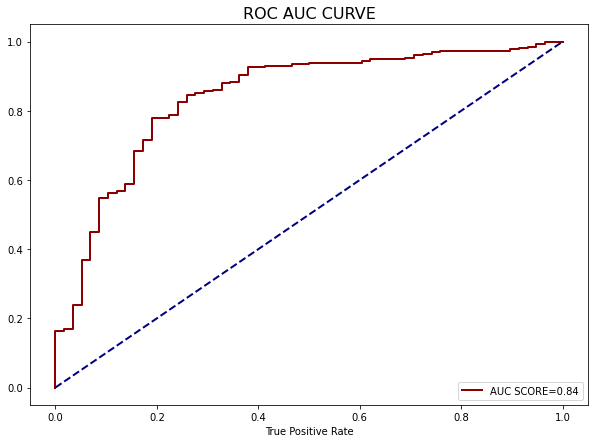

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(test_curve[0],test_curve[1],color='darkred', lw=2, label="AUC SCORE="+str(round(test_roc_auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE', fontsize = 16)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend(loc=4)
plt.show()